**Plan General para el Análisis del Dataset `ISCRAM_maria_tweets.csv`**

---

### 🔍 **1. Adaptación del Esquema de Análisis Propuesto**
- **Objetivo Principal:** Realizar un análisis multidimensional de tweets relacionados con el huracán María, integrando datos crudos, metadatos y técnicas avanzadas de NLP.
- **Diferencias Clave vs. el Ejemplo:**  
  - El dataset original incluye **métricas de engagement** (`like_count`, `retweet_count`), **fechas** (`created_at`) y **idiomas** (`lang`), lo que permite enriquecer el análisis con dimensiones temporales y sociales.  
  - No hay columnas predefinidas de `Label` o `Split`, por lo que se requerirá **crear categorías semánticas** basadas en contenido/texto.

---

### 📊 **2. Etapas Clave del Análisis**

#### **A. Preprocesamiento y Limpieza**  
- **Renombrar columnas** para claridad (ej: `id` → `tweet_id`, `text` → `tweet_text`).  
- **Limpieza textual:**  
  - Eliminar URLs, menciones (@), hashtags (#), caracteres especiales.  
  - Normalización (minúsculas, manejo de emojis/errores ortográficos).  
  - Detección de idioma (`lang`) para segmentar análisis por lenguaje (español/inglés).  
- **Crear columna `Clean_Text`** estandarizada.  

#### **B. Ingeniería de Features**  
- **Features básicos:**  
  - `Tweet_Length`: Longitud del texto.  
  - `Is_RT`: Identificación de retweets (si comienza con "RT").  
  - `Exclamation_Count`: Número de signos de exclamación.  
  - `Engagement_Score`: Combinación de `like_count` + `retweet_count`.  
- **Features semánticas:**  
  - **Detección de temas clave:**  
    - *Ayuda humanitaria* (`help`, `food`, `water`, `donate`).  
    - *Daños* (`destroyed`, `power outage`, `flood`).  
    - *Críticas/Política* (`Trump`, `government`, `FEMA`).  
  - **Extracción de entidades nombradas** (lugares, organizaciones).  

#### **C. Análisis Temporal**  
- **Series de tiempo:** Frecuencia de tweets por hora/día.  
- **Correlación** entre eventos climáticos (ej: impacto de María el 20/09/2017) y actividad en redes.  
- **Engagement por fase del desastre:** Comparar métricas antes/durante/después del huracán.  

#### **D. Análisis de Sentimiento y Emociones**  
- **Modelos multilingües** (ej: VADER para inglés, NLP en español para tweets en ese idioma).  
- **Clasificación emocional:**  
  - `Urgencia` (uso de exclamaciones, palabras clave).  
  - `Crítica` (mención a instituciones/figuras políticas).  
  - `Solidaridad` (llamados a donaciones/voluntariado).  

#### **E. Redes Sociales y Influencia**  
- **Análisis de usuarios:**  
  - Top usuarios por `retweet_count` (posibles influenciadores).  
  - Distribución geográfica basada en perfiles (`username`).  
- **Propagación de información:** Mapear redes de retweets para identificar nodos centrales.  

#### **F. Visualizaciones**  
- **Mapas de calor temporales** de actividad/engagement.  
- **Word Clouds** por categoría semántica (ej: ayuda vs. críticas).  
- **Gráficos de barras** para frecuencia de palabras clave vs. engagement.  
- **Clusterización** (t-SNE/UMAP) coloreada por sentimiento o tema.  

#### **G. Integración con Datos Externos**  
- **Enriquecer con datos oficiales:**  
  - Trayectoria del huracán (NOAA).  
  - Estadísticas de daños (FEMA, gobiernos locales).  
- **Cross-validación:** Comparar menciones en redes con reportes oficiales (ej: cortes de energía).  

---

### 🛠 **3. Herramientas Propuestas**  
- **Limpieza/Preprocesamiento:** `pandas`, `regex`, `langdetect`.  
- **NLP/Features:** `spaCy` (entidades), `nltk` (stopwords), `TextBlob` (sentimiento en español).  
- **Visualizaciones:** `matplotlib`, `seaborn`, `Plotly`, `WordCloud`.  
- **Análisis Temporal:** `statsmodels`, `prophet`.  
- **Redes:** `networkx`, `Gephi`.  

---

### ✅ **4. Entregables Esperados**  
1. **Dataset enriquecido** con features semánticas, temporalidad y sentimiento.  
2. **Reporte visual** interactivo (ej: Jupyter Notebook o Dash).  
3. **Insights accionables:**  
   - Patrones de comunicación durante crisis.  
   - Efectividad de mensajes clave (ej: tweets con alto engagement).  
   - Identificación de desinformación o brechas en la ayuda.  

---

Este plan busca no solo replicar la estructura del ejemplo, sino **ampliarla** con dimensiones únicas del dataset (metadatos de engagement, temporalidad, multilingüismo). ¿Necesitas ajustar algún componente?

Citations:
[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/59985647/9edd51ea-519c-4c58-90ad-430e0db5e5fa/ISCRAM_maria_tweets.csv


✅ Preprocesamiento completado y gráficos generados.


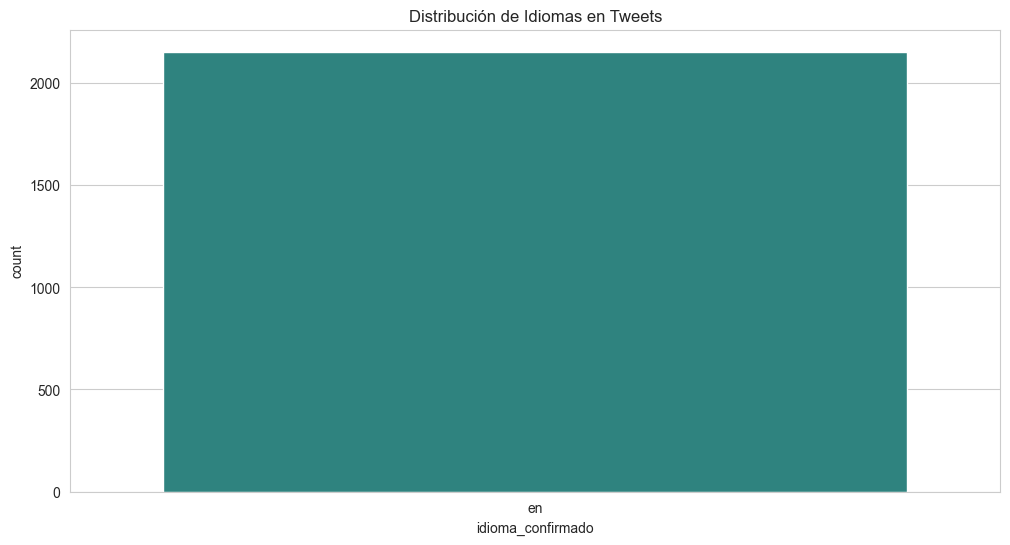

In [ ]:
import pandas as pd
import re
import emoji
from langdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos desde el archivo CSV
df = pd.read_csv('ISCRAM_maria_tweets.csv')

# Renombrar columnas para mayor claridad y eliminar duplicados basados en el ID del tweet
df = df.rename(columns={
    'id': 'tweet_id',
    'text': 'tweet_text',
    'created_at': 'fecha_creacion',
    'like_count': 'num_likes',
    'retweet_count': 'num_retweets',
    'lang': 'idioma_original',
    'username': 'usuario'
}).drop_duplicates(subset='tweet_id')

# Función para limpiar texto eliminando URLs, menciones, hashtags y caracteres especiales
def limpiar_texto(texto):
    if pd.isna(texto):  # Manejar valores nulos
        return ""
    
    # Eliminar URLs, menciones (@usuario) y hashtags (#hashtag)
    texto = re.sub(r'http\S+|www\S+|@\w+|#(\w+)', lambda m: m.group(1) if m.group(1) else '', texto)
    # Convertir emojis a texto (ejemplo: 😊 → :smile:)
    texto = emoji.demojize(texto, delimiters=(' ', ' '))
    # Eliminar caracteres no alfanuméricos y números, convertir a minúsculas
    texto = re.sub(r'[^\w\s]|[\d_]', ' ', texto.lower())
    # Eliminar espacios extra
    return re.sub(r'\s+', ' ', texto).strip()

# Aplicar limpieza de texto a la columna 'tweet_text'
df['texto_limpio'] = df['tweet_text'].astype(str).apply(limpiar_texto)

# Función para detectar el idioma del texto utilizando la librería langdetect
def detectar_idioma(texto):
    try:
        # Detectar idioma solo si el texto tiene más de 10 caracteres
        return detect(texto) if len(texto) > 10 else 'unknown'
    except:
        # Manejar excepciones en caso de errores en la detección
        return 'unknown'

# Crear una nueva columna con el idioma detectado
df['idioma_confirmado'] = df['texto_limpio'].apply(detectar_idioma)

# Convertir la columna de fechas a formato datetime con manejo de errores
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

# Filtrar tweets en inglés para análisis posterior
df = df[df['idioma_confirmado'] == 'en']

# Crear nuevas características basadas en el texto
df['longitud_texto'] = df['texto_limpio'].apply(len)  # Longitud del texto limpio
df['es_retweet'] = df['tweet_text'].str.startswith('RT').astype(int)  # Identificar si es un retweet
df['num_hashtags'] = df['tweet_text'].str.count(r'#\w+')  # Contar hashtags en el texto original
df['num_exclamaciones'] = df['tweet_text'].str.count(r'!')  # Contar signos de exclamación

# Guardar el dataset procesado en un nuevo archivo CSV
df.to_csv('maria_tweets_procesado.csv', index=False)

# Visualización de la distribución de idiomas detectados
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='idioma_confirmado', hue='idioma_confirmado', palette='viridis', legend=False)
plt.title('Distribución de Idiomas en Tweets')  # Título del gráfico
plt.savefig('distribucion_idiomas_actualizada.png', bbox_inches='tight')  # Guardar gráfico como imagen

# Mensaje de confirmación al finalizar el preprocesamiento
print("✅ Preprocesamiento completado y gráficos generados.")


# Análisis Univariado y Visualizaciones del Dataset de Tweets sobre el Huracán María

Este código realiza un análisis exhaustivo de las variables en tu dataset de tweets sobre el Huracán María, generando visualizaciones informativas para cada atributo:

### 1. Variables Numéricas

- **Longitud de texto**: El histograma muestra la distribución de caracteres en los tweets limpios, con una línea que marca la media.
- **Engagement (likes y retweets)**: Utilizamos boxplots con escala logarítmica para visualizar estas variables que suelen tener distribuciones sesgadas.
- **Hashtags y exclamaciones**: Histogramas que muestran cuántos tweets contienen diferentes cantidades de hashtags y signos de exclamación.

### 2. Variables Categóricas

- **Tweets originales vs. retweets**: Gráfico de barras

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import plotly.io as pio
from collections import Counter
import warnings
import os
from datetime import datetime

# Configuración inicial
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Crear directorio para guardar visualizaciones
if not os.path.exists('visualizaciones'):
    os.makedirs('visualizaciones')

# Función para guardar gráficos
def guardar_grafico(plt, nombre):
    plt.tight_layout()
    plt.savefig(f'visualizaciones/{nombre}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Cargar el dataset procesado
df = pd.read_csv('maria_tweets_procesado.csv')

# Convertir la columna de fechas a formato datetime
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion'], errors='coerce')

# 1. ANÁLISIS DE VARIABLES NUMÉRICAS
print("Estadísticas descriptivas de variables numéricas:")
print(df[['longitud_texto', 'num_likes', 'num_retweets', 'num_hashtags', 'num_exclamaciones']].describe())

# 1.1 Histograma de longitud de texto
plt.figure(figsize=(14, 8))
sns.histplot(df['longitud_texto'], bins=30, kde=True)
plt.title('Distribución de la Longitud de Texto en Tweets', fontsize=16)
plt.xlabel('Número de Caracteres', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.axvline(df['longitud_texto'].mean(), color='red', linestyle='--', 
            label=f'Media: {df["longitud_texto"].mean():.1f} caracteres')
plt.legend()
guardar_grafico(plt, '01_histograma_longitud_texto')

# 1.2 Boxplot de likes y retweets (escala logarítmica para mejor visualización)
plt.figure(figsize=(14, 8))
data_to_plot = [np.log1p(df['num_likes']), np.log1p(df['num_retweets'])]
plt.boxplot(data_to_plot, vert=True, patch_artist=True, 
            labels=['Likes (log)', 'Retweets (log)'])
plt.title('Distribución de Likes y Retweets (Escala Logarítmica)', fontsize=16)
plt.ylabel('Conteo (log(x+1))', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir puntos de datos para mejor visualización
for i, data in enumerate(data_to_plot):
    x = np.random.normal(i+1, 0.04, size=len(data))
    plt.scatter(x, data, alpha=0.4, s=10)

guardar_grafico(plt, '02_boxplot_engagement')

# 1.3 Histograma de hashtags y exclamaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['num_hashtags'], bins=range(0, df['num_hashtags'].max() + 2), kde=False, ax=axes[0])
axes[0].set_title('Distribución de Hashtags por Tweet', fontsize=14)
axes[0].set_xlabel('Número de Hashtags', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.histplot(df['num_exclamaciones'], bins=range(0, min(10, df['num_exclamaciones'].max()) + 2), kde=False, ax=axes[1])
axes[1].set_title('Distribución de Signos de Exclamación por Tweet', fontsize=14)
axes[1].set_xlabel('Número de Exclamaciones', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

guardar_grafico(plt, '03_histograma_hashtags_exclamaciones')

# 1.4 Gráfico de barras para tweets originales vs retweets
plt.figure(figsize=(10, 6))
retweet_counts = df['es_retweet'].value_counts()
colors = ['#2ecc71', '#3498db']
plt.bar(retweet_counts.index.map({0: 'Tweet Original', 1: 'Retweet'}), 
        retweet_counts.values, color=colors)
plt.title('Proporción de Tweets Originales vs Retweets', fontsize=16)
plt.ylabel('Número de Tweets', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir porcentajes sobre las barras
total = retweet_counts.sum()
for i, count in enumerate(retweet_counts):
    plt.text(i, count + 50, f'{count/total*100:.1f}%', 
             ha='center', fontsize=12)

guardar_grafico(plt, '04_barras_retweets')

# 1.5 Extraer hora del día si la columna fecha_creacion es válida
if not pd.api.types.is_datetime64_any_dtype(df['fecha_creacion']):
    # Intentar extraer hora usando regex si la conversión a datetime falló
    import re
    def extract_hour(date_str):
        if pd.isna(date_str):
            return None
        match = re.search(r'(\d{2}):(\d{2}):(\d{2})', str(date_str))
        if match:
            return int(match.group(1))
        return None
    
    df['hora'] = df['fecha_creacion'].apply(extract_hour)
else:
    df['hora'] = df['fecha_creacion'].dt.hour

# Verificar si tenemos datos de hora válidos
if 'hora' in df.columns and df['hora'].notna().any():
    hora_counts = df['hora'].value_counts().sort_index()
    
    # Gráfico de pastel para distribución temporal (hora del día)
    plt.figure(figsize=(12, 12))
    plt.pie(hora_counts, labels=[f'{h}:00' for h in hora_counts.index], 
            autopct='%1.1f%%', startangle=90, 
            wedgeprops={'edgecolor': 'white', 'linewidth': 1})
    plt.title('Distribución de Tweets por Hora del Día (UTC)', fontsize=16)
    plt.axis('equal')
    guardar_grafico(plt, '05_pie_distribucion_horas')

# 1.6 Extraer día de la semana si la columna fecha_creacion es válida
if pd.api.types.is_datetime64_any_dtype(df['fecha_creacion']):
    df['dia_semana'] = df['fecha_creacion'].dt.day_name()
    
    # Verificar si tenemos datos de día de semana válidos
    if 'dia_semana' in df.columns and df['dia_semana'].notna().any():
        dia_counts = df['dia_semana'].value_counts()
        
        # Ordenar los días de la semana
        dias_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dia_counts = dia_counts.reindex(dias_orden)
        
        # Gráfico de barras para días de la semana (alternativa a waffle)
        plt.figure(figsize=(12, 8))
        plt.bar(dia_counts.index, dia_counts.values, color=sns.color_palette("viridis", 7))
        plt.title('Distribución de Tweets por Día de la Semana', fontsize=16)
        plt.xlabel('Día de la Semana', fontsize=14)
        plt.ylabel('Número de Tweets', fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Añadir valores sobre las barras
        for i, count in enumerate(dia_counts):
            plt.text(i, count + 20, f'{count}', ha='center', fontsize=12)
            
        guardar_grafico(plt, '06_barras_dias_semana')

# 1.7 Análisis de palabras clave relacionadas con ayuda humanitaria
keywords_ayuda = ['help', 'food', 'water', 'rescue', 'donation', 'relief', 'aid', 'support', 'emergency']
for keyword in keywords_ayuda:
    df[f'contiene_{keyword}'] = df['texto_limpio'].str.contains(r'\b' + keyword + r'\b').astype(int)

# Gráfico de barras para palabras clave
plt.figure(figsize=(14, 8))
keyword_counts = [df[f'contiene_{keyword}'].sum() for keyword in keywords_ayuda]
keyword_percentages = [count/len(df)*100 for count in keyword_counts]

# Ordenar por frecuencia
sorted_indices = np.argsort(keyword_counts)[::-1]
sorted_keywords = [keywords_ayuda[i] for i in sorted_indices]
sorted_counts = [keyword_counts[i] for i in sorted_indices]
sorted_percentages = [keyword_percentages[i] for i in sorted_indices]

bars = plt.bar(sorted_keywords, sorted_counts, color=sns.color_palette("viridis", len(keywords_ayuda)))
plt.title('Frecuencia de Palabras Clave Relacionadas con Ayuda Humanitaria', fontsize=16)
plt.xlabel('Palabra Clave', fontsize=14)
plt.ylabel('Número de Tweets', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir porcentajes sobre las barras
for i, (count, percentage) in enumerate(zip(sorted_counts, sorted_percentages)):
    plt.text(i, count + 20, f'{percentage:.1f}%', ha='center', fontsize=12)

guardar_grafico(plt, '07_barras_palabras_clave')

# 1.8 FacetGrid para distribución de longitud de texto por día de la semana
if 'dia_semana' in df.columns and df['dia_semana'].notna().any():
    g = sns.FacetGrid(df, col="dia_semana", col_wrap=3, height=4, col_order=dias_orden)
    g.map(sns.histplot, "longitud_texto", bins=20, kde=True)
    g.set_axis_labels("Longitud del Texto", "Frecuencia")
    g.set_titles("{col_name}")
    g.fig.suptitle('Distribución de Longitud de Texto por Día de la Semana', fontsize=16, y=1.02)
    guardar_grafico(plt, '08_facetgrid_longitud_dias')

# 1.9 Nube de palabras general
stopwords = set(STOPWORDS)
stopwords.update(['rt', 'https', 'co', 'amp', 'the', 'and', 'for', 'this', 'that', 'with', 'are', 'not'])

all_words = ' '.join(df['texto_limpio'])
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    colormap='viridis',
    contour_width=1,
    contour_color='steelblue'
).generate(all_words)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Todos los Tweets', fontsize=16)
guardar_grafico(plt, '09_wordcloud_general')

# 1.10 Nubes de palabras separadas por tweets originales vs retweets
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Nube para tweets originales
original_tweets = ' '.join(df[df['es_retweet'] == 0]['texto_limpio'])
wordcloud_original = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    colormap='viridis'
).generate(original_tweets)

axes[0].imshow(wordcloud_original, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Palabras en Tweets Originales', fontsize=14)

# Nube para retweets
retweets = ' '.join(df[df['es_retweet'] == 1]['texto_limpio'])
wordcloud_retweets = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    colormap='plasma'
).generate(retweets)

axes[1].imshow(wordcloud_retweets, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Palabras en Retweets', fontsize=14)

plt.suptitle('Comparación de Vocabulario: Tweets Originales vs Retweets', fontsize=16, y=0.98)
guardar_grafico(plt, '10_wordcloud_comparacion')

# 1.11 Análisis de engagement (likes + retweets)
df['engagement_total'] = df['num_likes'] + df['num_retweets']

plt.figure(figsize=(14, 8))
sns.histplot(np.log1p(df['engagement_total']), bins=30, kde=True)
plt.title('Distribución del Engagement Total (Escala Logarítmica)', fontsize=16)
plt.xlabel('Log(Engagement + 1)', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
guardar_grafico(plt, '11_histograma_engagement')

# 1.12 Visualización interactiva con Plotly (guardar como HTML)
try:
    fig = px.scatter(df, 
                    x='num_retweets', 
                    y='num_likes',
                    size='longitud_texto',
                    color='es_retweet',
                    hover_data=['usuario', 'texto_limpio'],
                    log_x=True, 
                    log_y=True,
                    title='Relación entre Likes y Retweets (Escala Logarítmica)')

    fig.update_layout(
        xaxis_title='Número de Retweets (log)',
        yaxis_title='Número de Likes (log)',
        legend_title='Es Retweet'
    )

    pio.write_html(fig, 'visualizaciones/12_scatter_interactivo.html')
except Exception as e:
    print(f"Error al generar gráfico interactivo: {e}")

# 2. RELACIONES ENTRE VARIABLES

# 2.1 Matriz de correlación
correlation_vars = ['longitud_texto', 'num_likes', 'num_retweets', 'num_hashtags', 
                    'num_exclamaciones', 'es_retweet', 'engagement_total']
correlation_matrix = df[correlation_vars].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Variables', fontsize=16)
guardar_grafico(plt, '13_correlation_matrix')

# 2.2 Relación entre longitud del texto y engagement
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='longitud_texto', y=np.log1p(df['engagement_total']), 
                hue='es_retweet', alpha=0.6)
plt.title('Relación entre Longitud del Texto y Engagement', fontsize=16)
plt.xlabel('Longitud del Texto', fontsize=14)
plt.ylabel('Log(Engagement + 1)', fontsize=14)
plt.legend(title='Es Retweet', labels=['Tweet Original', 'Retweet'])
guardar_grafico(plt, '14_scatter_longitud_engagement')

# 2.3 Relación entre número de hashtags y engagement
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='num_hashtags', y=np.log1p(df['engagement_total']))
plt.title('Relación entre Número de Hashtags y Engagement', fontsize=16)
plt.xlabel('Número de Hashtags', fontsize=14)
plt.ylabel('Log(Engagement + 1)', fontsize=14)
plt.xticks(range(0, min(8, df['num_hashtags'].max() + 1)))
guardar_grafico(plt, '15_boxplot_hashtags_engagement')

# 2.4 Análisis de palabras clave y engagement
plt.figure(figsize=(14, 8))
keyword_engagement = []
for keyword in keywords_ayuda:
    mean_engagement = np.log1p(df[df[f'contiene_{keyword}'] == 1]['engagement_total']).mean()
    keyword_engagement.append(mean_engagement)

# Ordenar por engagement promedio
sorted_indices = np.argsort(keyword_engagement)[::-1]
sorted_keywords = [keywords_ayuda[i] for i in sorted_indices]
sorted_engagement = [keyword_engagement[i] for i in sorted_indices]

plt.bar(sorted_keywords, sorted_engagement, color=sns.color_palette("viridis", len(keywords_ayuda)))
plt.title('Engagement Promedio por Palabra Clave (Escala Logarítmica)', fontsize=16)
plt.xlabel('Palabra Clave', fontsize=14)
plt.ylabel('Log(Engagement Promedio + 1)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
guardar_grafico(plt, '16_barras_keywords_engagement')

# 2.5 Análisis temporal del engagement si la fecha es válida
if pd.api.types.is_datetime64_any_dtype(df['fecha_creacion']):
    df['fecha'] = df['fecha_creacion'].dt.date
    engagement_by_date = df.groupby('fecha')['engagement_total'].mean().reset_index()
    
    plt.figure(figsize=(14, 8))
    plt.plot(engagement_by_date['fecha'], engagement_by_date['engagement_total'], 
             marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.title('Evolución Temporal del Engagement Promedio', fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Engagement Promedio', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    guardar_grafico(plt, '17_linea_engagement_tiempo')

    # 2.6 Análisis de engagement por hora del día
    if 'hora' in df.columns and df['hora'].notna().any():
        engagement_by_hour = df.groupby('hora')['engagement_total'].mean().reset_index()
        
        plt.figure(figsize=(14, 8))
        plt.bar(engagement_by_hour['hora'], engagement_by_hour['engagement_total'], 
                color=sns.color_palette("viridis", 24))
        plt.title('Engagement Promedio por Hora del Día', fontsize=16)
        plt.xlabel('Hora del Día (UTC)', fontsize=14)
        plt.ylabel('Engagement Promedio', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(range(0, 24))
        guardar_grafico(plt, '18_barras_engagement_hora')

# 3. ANÁLISIS DE CONTENIDO TEXTUAL

# 3.1 Análisis de frecuencia de palabras
from collections import Counter
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Obtener stopwords en inglés
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', 'https', 'co', 'amp', 'the', 'and', 'for', 'this', 'that', 'with', 'are', 'not'])

# Función para obtener palabras más frecuentes
def get_top_words(text_series, n=20):
    words = ' '.join(text_series).lower().split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n)

# Palabras más frecuentes en todo el dataset
top_words = get_top_words(df['texto_limpio'])

plt.figure(figsize=(14, 8))
words, counts = zip(*top_words)
plt.bar(words, counts, color=sns.color_palette("viridis", len(top_words)))
plt.title('Palabras Más Frecuentes en Tweets sobre el Huracán María', fontsize=16)
plt.xlabel('Palabras', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
guardar_grafico(plt, '19_barras_palabras_frecuentes')

# 3.2 Análisis de bigramas
from nltk.util import ngrams

# Función para obtener bigramas más frecuentes
def get_top_bigrams(text_series, n=20):
    all_bigrams = []
    for text in text_series:
        tokens = text.lower().split()
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        bi_tokens = list(ngrams(tokens, 2))
        all_bigrams.extend(bi_tokens)
    return Counter(all_bigrams).most_common(n)

# Bigramas más frecuentes
top_bigrams = get_top_bigrams(df['texto_limpio'])

plt.figure(figsize=(14, 8))
bigrams, counts = zip(*top_bigrams)
bigram_labels = [f"{b[0]} {b[1]}" for b in bigrams]
plt.bar(bigram_labels, counts, color=sns.color_palette("viridis", len(top_bigrams)))
plt.title('Bigramas Más Frecuentes en Tweets sobre el Huracán María', fontsize=16)
plt.xlabel('Bigramas', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
guardar_grafico(plt, '20_barras_bigramas_frecuentes')

# 3.3 Análisis de sentimiento (básico)
from textblob import TextBlob

# Función para obtener polaridad del sentimiento
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0

# Aplicar análisis de sentimiento
df['sentimiento'] = df['texto_limpio'].apply(get_sentiment)

# Categorizar sentimiento
def categorize_sentiment(polarity):
    if polarity > 0.1:
        return 'Positivo'
    elif polarity < -0.1:
        return 'Negativo'
    else:
        return 'Neutral'

df['categoria_sentimiento'] = df['sentimiento'].apply(categorize_sentiment)

# Gráfico de distribución de sentimiento
plt.figure(figsize=(12, 8))
sentiment_counts = df['categoria_sentimiento'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
        colors=['#2ecc71', '#f1c40f', '#e74c3c'], startangle=90, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Distribución de Sentimiento en Tweets sobre el Huracán María', fontsize=16)
plt.axis('equal')
guardar_grafico(plt, '21_pie_sentimiento')

# 3.4 Relación entre sentimiento y engagement
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='categoria_sentimiento', y=np.log1p(df['engagement_total']))
plt.title('Relación entre Sentimiento y Engagement', fontsize=16)
plt.xlabel('Categoría de Sentimiento', fontsize=14)
plt.ylabel('Log(Engagement + 1)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
guardar_grafico(plt, '22_boxplot_sentimiento_engagement')

# 3.5 Análisis de palabras por categoría de sentimiento
for sentiment in ['Positivo', 'Negativo', 'Neutral']:
    sentiment_words = get_top_words(df[df['categoria_sentimiento'] == sentiment]['texto_limpio'], 15)
    
    plt.figure(figsize=(12, 6))
    words, counts = zip(*sentiment_words)
    plt.bar(words, counts, color=sns.color_palette("viridis", len(sentiment_words)))
    plt.title(f'Palabras Más Frecuentes en Tweets con Sentimiento {sentiment}', fontsize=16)
    plt.xlabel('Palabras', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    guardar_grafico(plt, f'23_barras_palabras_{sentiment.lower()}')

print("\n✅ Análisis completo. Todas las visualizaciones han sido guardadas en el directorio 'visualizaciones'.")



Estadísticas descriptivas de variables numéricas:
       longitud_texto    num_likes  num_retweets  num_hashtags  \
count     2154.000000  2154.000000   2154.000000   2154.000000   
mean        99.062210     0.681058   1292.069174      0.687558   
std         28.610682    19.148161   5662.047569      1.232537   
min         12.000000     0.000000      0.000000      0.000000   
25%         80.000000     0.000000      3.000000      0.000000   
50%        107.000000     0.000000    207.000000      0.000000   
75%        121.000000     0.000000   1080.000000      1.000000   
max        278.000000   844.000000  89163.000000     12.000000   

       num_exclamaciones  
count        2154.000000  
mean            0.090994  
std             0.422413  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.000000  
max             7.000000  


ModuleNotFoundError: No module named 'textblob'